# Section A

In [61]:
%run NASA_log_analytics

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

### Loading and Parsing NASA Log Dataset and Format Columns

In [49]:
logs_df = create_logs_df()
logs_df = logs_df[logs_df['status'].isNotNull()]

logs_df.show(10, truncate=False)
print((logs_df.count(), len(logs_df.columns)))

+-------------+-------------------+--------------------+------+-----------------------------------------------+--------+------+------------+
|Day in a week|timestamp          |host                |method|endpoint                                       |protocol|status|content_size|
+-------------+-------------------+--------------------+------+-----------------------------------------------+--------+------+------------+
|Saturday     |1995-07-01 00:00:01|199.72.81.55        |GET   |/history/apollo/                               |HTTP/1.0|200   |6245        |
|Saturday     |1995-07-01 00:00:06|unicomp6.unicomp.net|GET   |/shuttle/countdown/                            |HTTP/1.0|200   |3985        |
|Saturday     |1995-07-01 00:00:09|199.120.110.21      |GET   |/shuttle/missions/sts-73/mission-sts-73.html   |HTTP/1.0|200   |4085        |
|Saturday     |1995-07-01 00:00:11|burger.letters.com  |GET   |/shuttle/countdown/liftoff.html                |HTTP/1.0|304   |0           |
|Saturday    

(3461612, 8)


### Handling Missing Data

Count the total number of rows has missing values


In [27]:
count_null(logs_df)

33904

Count the number of missing values for each column

In [30]:
count_null_cols(logs_df).show()

+-------------+----+---------+------+--------+--------+------+------------+
|Day in a week|host|timestamp|method|endpoint|protocol|status|content_size|
+-------------+----+---------+------+--------+--------+------+------------+
|            0|   0|        0|     0|       0|       0|     0|       33904|
+-------------+----+---------+------+--------+--------+------+------------+



### Fix the rows with null content_size



In [34]:
logs_df = fill_null(logs_df)
count_null_cols(logs_df).show()

+-------------+----+---------+------+--------+--------+------+------------+
|Day in a week|host|timestamp|method|endpoint|protocol|status|content_size|
+-------------+----+---------+------+--------+--------+------+------------+
|            0|   0|        0|     0|       0|       0|     0|           0|
+-------------+----+---------+------+--------+--------+------+------------+



Now we use this function and fill all the missing values in the content_size field with 0!

### Content Size

In [50]:
content_size_summary_df = logs_df.describe(['content_size'])
content_size_summary_df.toPandas()

,summary,content_size
0,count,3427708
1,mean,19116.072581153352
2,stddev,73367.3795143063
3,min,0
4,max,6823936


In [57]:
(logs_df.agg(F.min(logs_df['content_size']).alias('min_content_size'),
             F.max(logs_df['content_size']).alias('max_content_size'),
             F.mean(logs_df['content_size']).alias('mean_content_size'),
             F.stddev(logs_df['content_size']).alias('std_content_size'),
             F.count(logs_df['content_size']).alias('count_content_size'))
        .toPandas())

,min_content_size,max_content_size,mean_content_size,std_content_size,count_content_size
0,0,6823936,19116.072581,73367.379514,3427708


### HTTP Status Code Analysis

In [59]:
status_freq_df = (logs_df
                     .groupBy('status')
                     .count()
                     .sort('status')
                     .cache())
print('Total distinct HTTP Status Codes:', status_freq_df.count())      

23/06/30 22:01:27 WARN CacheManager: Asked to cache already cached data.


Total distinct HTTP Status Codes: 8


In [62]:
status_freq = status_Count_by_Day(logs_df)
status_freq.show(truncate=False)

+------+-------+
|status|count  |
+------+-------+
|200   |3100524|
|304   |266773 |
|302   |73070  |
|404   |20899  |
|403   |225    |
|500   |65     |
|501   |41     |
|400   |15     |
+------+-------+



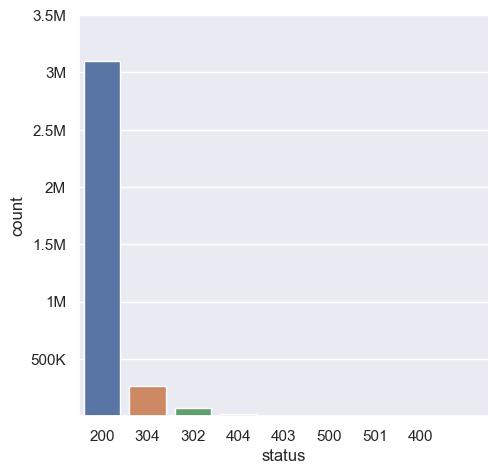

In [ ]:
sns.set_theme()

status_freq_df = status_freq.toPandas().sort_values(by=['count'], ascending=False)
status_freq_df['status'] = status_freq_df['status'].astype(str)
status_freq_df['count'] = status_freq_df['count'].astype(int)
sns.catplot(x='status', y='count', data=status_freq_df, 
            kind='bar')
# I want to adjust the y-axis labels to be more readable
plt.yticks([500000, 1000000, 1500000, 2000000, 2500000, 3000000, 3500000],
              ['500K', '1M', '1.5M', '2M', '2.5M', '3M', '3.5M'])
plt.show()

In [ ]:
# Since the status code 200 is the most frequent, I want to see the top 10 endpoints that have status code 200
logs_df.createOrReplaceTempView("invocations")

query = """
SELECT endpoint, COUNT(*) AS count
FROM invocations
WHERE status == 200
GROUP BY endpoint
ORDER BY count DESC
LIMIT 10
"""
result = ss.sql(query)

result.show(truncate=False)

+---------------------------------------+------+
|endpoint                               |count |
+---------------------------------------+------+
|/images/NASA-logosmall.gif             |168632|
|/images/KSC-logosmall.gif              |141207|
|/images/MOSAIC-logosmall.gif           |112663|
|/images/USA-logosmall.gif              |111932|
|/images/WORLD-logosmall.gif            |111152|
|/images/ksclogo-medium.gif             |108013|
|/ksc.html                              |79993 |
|/images/launch-logo.gif                |67200 |
|/history/apollo/images/apollo-logo1.gif|61407 |
|/shuttle/countdown/                    |59177 |
+---------------------------------------+------+



### Status Frequence in Log Scale

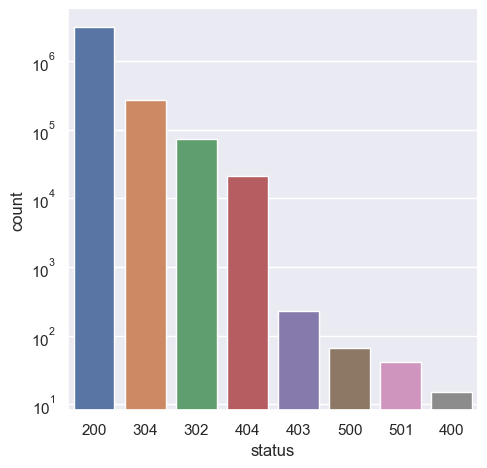

In [ ]:
#Since the y-axis labels are not readable, I want to adjust the y-axis labels to be more readable -> using log scale
sns.set_theme()

status_freq_df = status_freq.toPandas().sort_values(by=['count'], ascending=False)
status_freq_df['status'] = status_freq_df['status'].astype(str)
status_freq_df['count'] = status_freq_df['count'].astype(int)
sns.catplot(x='status', y='count', data=status_freq_df, 
            kind='bar')
# I want to adjust the y-axis labels to be more readable
plt.yticks([500000, 1000000, 1500000, 2000000, 2500000, 3000000, 3500000],
              ['500K', '1M', '1.5M', '2M', '2.5M', '3M', '3.5M'])
plt.yscale('log')
plt.show()


### Analyzing Frequent Hosts

In [ ]:
top_host_df = top_host(logs_df)
top_host_df.show(10, truncate=False)

+--------------------+-----+
|host                |count|
+--------------------+-----+
|piweba3y.prodigy.com|21988|
|piweba4y.prodigy.com|16437|
|piweba1y.prodigy.com|12825|
|edams.ksc.nasa.gov  |11964|
|163.206.89.4        |9697 |
|news.ti.com         |8161 |
|www-d1.proxy.aol.com|8047 |
|alyssa.prodigy.com  |8037 |
|                    |7660 |
|siltb10.orl.mmc.com |7573 |
+--------------------+-----+
only showing top 10 rows



### Display the Top 20 Frequent EndPoints

In [ ]:
top_endpoint_df = top_10_endpoint(logs_df)
top_endpoint_df.show(10, truncate=False)

+---------------------------------------+------+
|endpoint                               |count |
+---------------------------------------+------+
|/images/NASA-logosmall.gif             |208714|
|/images/KSC-logosmall.gif              |164970|
|/images/MOSAIC-logosmall.gif           |127908|
|/images/USA-logosmall.gif              |127074|
|/images/WORLD-logosmall.gif            |125925|
|/images/ksclogo-medium.gif             |121572|
|/ksc.html                              |83909 |
|/images/launch-logo.gif                |76006 |
|/history/apollo/images/apollo-logo1.gif|68896 |
|/shuttle/countdown/                    |64736 |
+---------------------------------------+------+



### Top Ten Error Endpoints


In [63]:
not200_df = (logs_df
               .filter(logs_df['status'] != 200))

error_endpoints_freq_df = (not200_df
                               .groupBy('endpoint')
                               .count()
                               .sort('count', ascending=False)
                               .limit(10)
                          )
                          
error_endpoints_freq_df.show(truncate=False)  

+---------------------------------------+-----+
|endpoint                               |count|
+---------------------------------------+-----+
|/images/NASA-logosmall.gif             |40082|
|/images/KSC-logosmall.gif              |23763|
|/images/MOSAIC-logosmall.gif           |15245|
|/images/USA-logosmall.gif              |15142|
|/images/WORLD-logosmall.gif            |14773|
|/images/ksclogo-medium.gif             |13559|
|/images/launch-logo.gif                |8806 |
|/history/apollo/images/apollo-logo1.gif|7489 |
|/                                      |6296 |
|/images/ksclogosmall.gif               |5669 |
+---------------------------------------+-----+



### Total number of Unique Hosts


In [64]:
unique_host_count = (logs_df
                     .select('host')
                     .distinct()
                     .count())
unique_host_count

137933

### Number of Unique Daily Hosts


In [66]:
host_day_df = logs_df.select(logs_df.host, 
                             F.dayofmonth('timestamp').alias('day'))
host_day_df.show(5, truncate=False)

+--------------------+---+
|host                |day|
+--------------------+---+
|199.72.81.55        |1  |
|unicomp6.unicomp.net|1  |
|199.120.110.21      |1  |
|burger.letters.com  |1  |
|199.120.110.21      |1  |
+--------------------+---+
only showing top 5 rows



In [67]:
host_day_distinct_df = (host_day_df
                          .dropDuplicates())
host_day_distinct_df.show(5, truncate=False)

+-----------------------+---+
|host                   |day|
+-----------------------+---+
|129.94.144.152         |1  |
|slip1.yab.com          |1  |
|205.184.190.47         |1  |
|204.120.34.71          |1  |
|ppp3_130.bekkoame.or.jp|1  |
+-----------------------+---+
only showing top 5 rows



In [74]:
host_day_df = logs_df.select(logs_df.host, F.dayofmonth('timestamp').alias('day'))
host_day_distinct_df = (host_day_df.dropDuplicates())
# aggregate by the day of month
daily_hosts_df = (host_day_distinct_df
                     .groupBy('day')
                     .count()
                     .sort("day"))
daily_hosts_df.show(truncate=False)

+---+-----+
|day|count|
+---+-----+
|1  |7609 |
|2  |4858 |
|3  |10238|
|4  |9411 |
|5  |9640 |
|6  |10133|
|7  |10048|
|8  |7112 |
|9  |6699 |
|10 |8532 |
|11 |8786 |
|12 |8135 |
|13 |9567 |
|14 |9302 |
|15 |7126 |
|16 |7143 |
|17 |8840 |
|18 |8262 |
|19 |7237 |
|20 |7072 |
+---+-----+
only showing top 20 rows



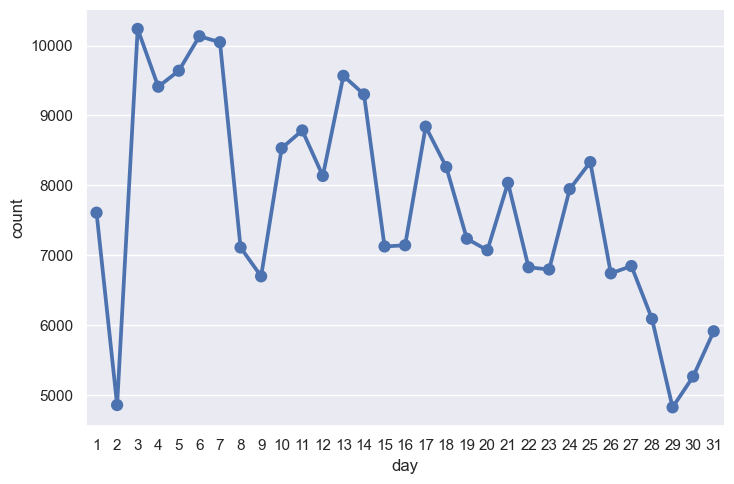

In [78]:
daily_hosts_df = daily_hosts_df.toPandas()
c = sns.catplot(x='day', y='count', 
                data=daily_hosts_df, 
                kind='point', height=5, 
                aspect=1.5)

### Average Number of Daily Requests per Host


In [80]:
daily_hosts_df = (host_day_distinct_df
                     .groupBy('day')
                     .count()
                     .select(col("day"), 
                                      col("count").alias("total_hosts")))

total_daily_reqests_df = (logs_df
                              .select(F.dayofmonth("timestamp")
                                          .alias("day"))
                              .groupBy("day")
                              .count()
                              .select(col("day"), 
                                      col("count").alias("total_reqs")))

avg_daily_reqests_per_host_df = total_daily_reqests_df.join(daily_hosts_df, 'day')
avg_daily_reqests_per_host_df = (avg_daily_reqests_per_host_df
                                    .withColumn('avg_reqs', col('total_reqs') / col('total_hosts'))
                                    .sort("day"))
avg_daily_reqests_per_host_df = avg_daily_reqests_per_host_df.toPandas()
avg_daily_reqests_per_host_df

,day,total_reqs,total_hosts,avg_reqs
0,1,98710,7609,12.972795
1,2,60265,4858,12.405311
2,3,130972,10238,12.792733
3,4,130009,9411,13.814579
4,5,126468,9640,13.119087
5,6,133380,10133,13.162933
6,7,144595,10048,14.390426
7,8,99024,7112,13.923510
8,9,95730,6699,14.290193
9,10,134108,8532,15.718237


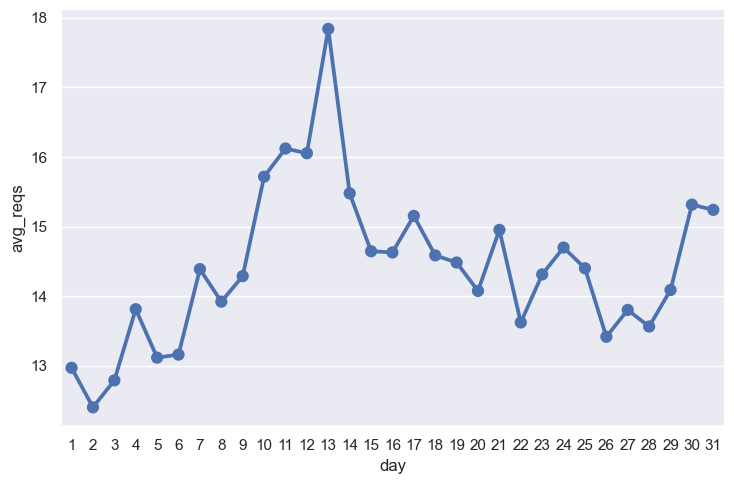

In [81]:
c = sns.catplot(x='day', y='avg_reqs', 
                data=avg_daily_reqests_per_host_df, 
                kind='point', height=5, aspect=1.5)

### Counting 404 Response Codes

In [82]:
not_found_df = logs_df.filter(logs_df["status"] == 404).cache()
print(('Total 404 responses: {}').format(not_found_df.count()))

Total 404 responses: 20899


### Listing the Top Twenty 404 Response Code Endpoints


In [83]:
endpoints_404_count_df = (not_found_df
                          .groupBy("endpoint")
                          .count()
                          .sort("count", ascending=False)
                          .limit(20))

endpoints_404_count_df.show(truncate=False)

+-----------------------------------------------------------------+-----+
|endpoint                                                         |count|
+-----------------------------------------------------------------+-----+
|/pub/winvn/readme.txt                                            |2004 |
|/pub/winvn/release.txt                                           |1732 |
|/shuttle/missions/STS-69/mission-STS-69.html                     |683  |
|/shuttle/missions/sts-68/ksc-upclose.gif                         |428  |
|/history/apollo/a-001/a-001-patch-small.gif                      |384  |
|/history/apollo/sa-1/sa-1-patch-small.gif                        |383  |
|/://spacelink.msfc.nasa.gov                                      |381  |
|/images/crawlerway-logo.gif                                      |374  |
|/elv/DELTA/uncons.htm                                            |372  |
|/history/apollo/pad-abort-test-1/pad-abort-test-1-patch-small.gif|359  |
|/images/nasa-logo.gif                

### Listing the Top Twenty 404 Response Code Hosts


In [84]:
hosts_404_count_df = (not_found_df
                          .groupBy("host")
                          .count()
                          .sort("count", ascending=False)
                          .limit(20))

hosts_404_count_df.show(truncate=False)

+---------------------------+-----+
|host                       |count|
+---------------------------+-----+
|hoohoo.ncsa.uiuc.edu       |251  |
|piweba3y.prodigy.com       |157  |
|jbiagioni.npt.nuwc.navy.mil|132  |
|piweba1y.prodigy.com       |114  |
|                           |112  |
|www-d4.proxy.aol.com       |91   |
|piweba4y.prodigy.com       |86   |
|scooter.pa-x.dec.com       |69   |
|www-d1.proxy.aol.com       |64   |
|phaelon.ksc.nasa.gov       |64   |
|www-b4.proxy.aol.com       |62   |
|dialip-217.den.mmc.com     |62   |
|www-b3.proxy.aol.com       |61   |
|www-a2.proxy.aol.com       |60   |
|piweba2y.prodigy.com       |59   |
|www-d2.proxy.aol.com       |59   |
|alyssa.prodigy.com         |56   |
|monarch.eng.buffalo.edu    |56   |
|www-b2.proxy.aol.com       |53   |
|www-c4.proxy.aol.com       |53   |
+---------------------------+-----+



### Visualizing 404 Errors per Day


In [86]:
errors_by_date_sorted_df = (not_found_df
                                .groupBy(F.dayofmonth('timestamp').alias('day'))
                                .count()
                                .sort("day"))

errors_by_date_sorted_pd_df = errors_by_date_sorted_df.toPandas()
errors_by_date_sorted_pd_df

,day,count
0,1,559
1,2,291
2,3,778
3,4,705
4,5,733
5,6,1013
6,7,1107
7,8,691
8,9,627
9,10,713


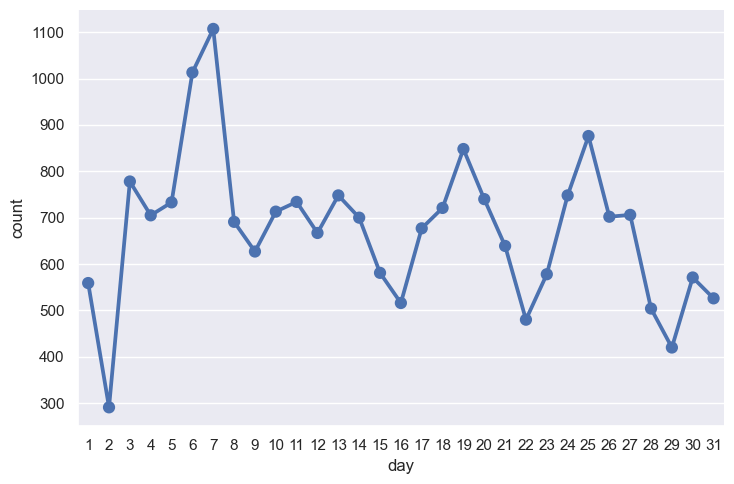

In [87]:
c = sns.catplot(x='day', y='count', 
                data=errors_by_date_sorted_pd_df, 
                kind='point', height=5, aspect=1.5)

### Top Three Days for 404 Errors


In [88]:
(errors_by_date_sorted_df
    .sort("count", ascending=False)
    .show(3))

+---+-----+
|day|count|
+---+-----+
|  7| 1107|
|  6| 1013|
| 25|  876|
+---+-----+
only showing top 3 rows



### Visualizing Hourly 404 Errors


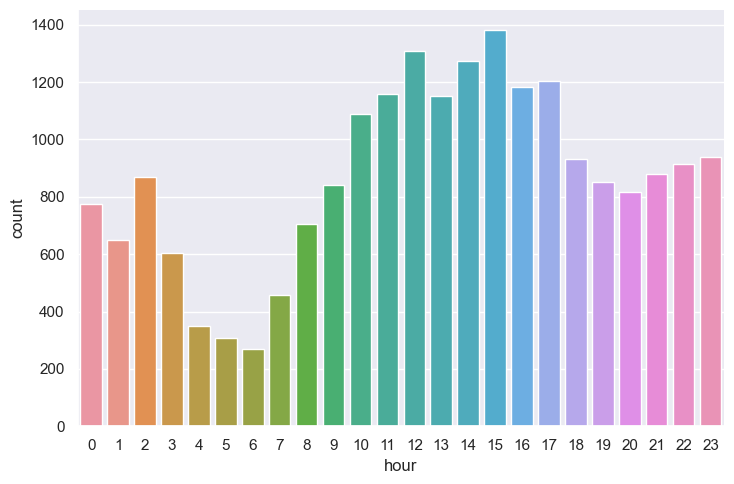

In [90]:
hourly_avg_errors_sorted_df = (not_found_df
                                   .groupBy(F.hour('timestamp')
                                             .alias('hour'))
                                   .count()
                                   .sort('hour'))
hourly_avg_errors_sorted_pd_df = hourly_avg_errors_sorted_df.toPandas()

c = sns.catplot(x='hour', y='count', 
                data=hourly_avg_errors_sorted_pd_df, 
                kind='bar', height=5, aspect=1.5)

## 3.1
Generate the output presenting the endpoint that received the highest number of invocations on a specific day of the week, along with the corresponding count of invocations.

In [5]:
top_invocation = endpoint_invocations_by_day(logs_df)

top_invocation.show(truncate=False)

+-------------+--------------------------+-----+
|Day in a week|endpoint                  |count|
+-------------+--------------------------+-----+
|Wednesday    |/images/NASA-logosmall.gif|37598|
|Tuesday      |/images/NASA-logosmall.gif|33685|
|Friday       |/images/NASA-logosmall.gif|29139|
|Thursday     |/images/NASA-logosmall.gif|46920|
|Saturday     |/images/NASA-logosmall.gif|16168|
|Monday       |/images/NASA-logosmall.gif|30380|
|Sunday       |/images/KSC-logosmall.gif |15218|
+-------------+--------------------------+-----+



## 3.2
Total number of 404 status codes generated in each day of a week(For Monday, Tuesday,..… Sunday) for the entire dataset.

In [3]:
status404_Count = status404_Count_by_Day(logs_df)

status404_Count.show(truncate=False)

+-------------+------+-----+
|Day in a week|status|count|
+-------------+------+-----+
|Friday       |404   |2691 |
|Tuesday      |404   |3425 |
|Monday       |404   |3145 |
|Sunday       |404   |2400 |
|Wednesday    |404   |3397 |
|Thursday     |404   |3772 |
|Saturday     |404   |2069 |
+-------------+------+-----+



<AxesSubplot: xlabel='Day in a week', ylabel='count'>

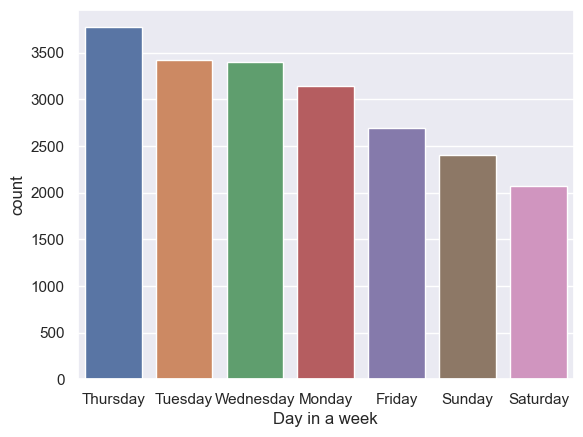

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

status_df = (status404_Count.toPandas().sort_values(by=['count'], ascending=False))

# using lineplot 
sns.lineplot(x='Day in a week', y='count', data=status_df) 

# sns.barplot(x='Day in a week', y='count', data=status_df)